In [2]:
import pandas as pd 
import numpy as np


import matplotlib.pyplot as plt

import torch
import torch.nn as nn
torch.manual_seed(42)

import seaborn as sns; sns.set()

sns.set_style('whitegrid')

In [3]:
def get_data(url='./art_daily_small_noise.csv'):
    '''
    inputs:
    ____________________________
    url (string): path to file
    
    returns:
    ________________________
    
    out: pandas dataframe
    
    '''
    df=pd.read_csv(url, index_col='timestamp',parse_dates=True)
    df.plot(legend=False)
    
    return df
    
    
    

data without anomaly


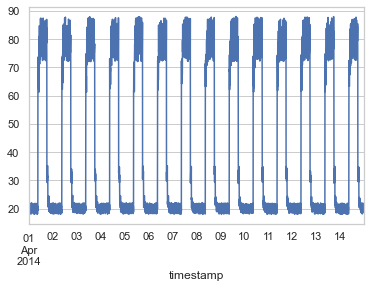

In [353]:
df_noise=get_data()

print('data without anomaly')

In [152]:
length_Seq=int(df_noise.groupby(df_noise.index.day).count().loc[1].values)

In [354]:
from sklearn.preprocessing import MinMaxScaler

sc=MinMaxScaler().fit(df_noise)

df_noise=sc.transform(df_noise)

In [100]:

def create_S(values, length_Seq=length_Seq):
    output=[]
    for i in range(len(values)-length_Seq):
        output.append(values[i:(i+length_Seq)].reshape(1,-1))
    return np.stack(output)    
        

In [92]:
seq=create_S(df_noise, length_Seq)
seq=torch.tensor(seq)

In [93]:
seq.size()

torch.Size([3744, 1, 288])

### Building an autoencodeur for detecting anomalies

artificialNoAnomaly/

Artifically-generated data without any anomalies.

artificialWithAnomaly/

In [94]:
class Ae(nn.Module):
    def __init__(self):
        super(Ae,self).__init__()
        self.encoder=nn.Sequential(
            nn.Conv1d(in_channels=seq.shape[1],out_channels=32, kernel_size=7),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels=32,out_channels=16,kernel_size=7),
            nn.ReLU(True)
                                )
        
        
        self.decoder=nn.Sequential(
            nn.ConvTranspose1d(in_channels=16,out_channels=16,kernel_size=7),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(in_channels=16,out_channels=32,kernel_size=7),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32,out_channels=seq.shape[1],kernel_size=1)
                                )
        
        
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [95]:
lr=0.001
epochs=10
history=[]

model=Ae().double()
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr)

for epoch in range(epochs):
    for s in seq:
        s.resize_(1,1,s.shape[1])
        output=model(s)
        loss=criterion(output,s)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
    history.append(loss.item())    
        
        
        
        
        

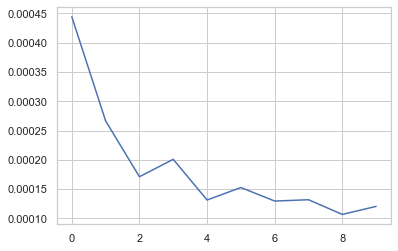

In [96]:
plt.plot(history)

In [390]:
model=model.eval()

In [391]:
val=np.stack(np.vsplit(df_noise,14))

In [392]:
def predict(val):
    predictions=[]
    with torch.no_grad():
        for i in range(val.shape[0]):
            pred=model(torch.tensor(val[i].reshape(1,1,288)))
            predictions.append(pred.numpy().flatten())


    return np.array(predictions).flatten().reshape(-1,1)       

In [393]:
predictions=predict(val)

In [394]:
mae_loss = np.mean(np.abs(predictions - df_noise), axis=1)

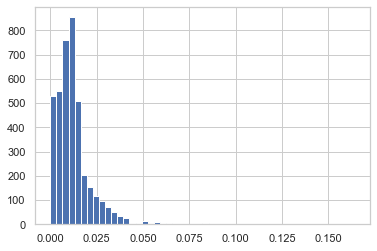

In [395]:
plt.hist(mae_loss, bins=50);

In [400]:
threshold=np.max(mae_loss)

print('threshold: ',threshold)

threshold:  0.1643086446050721


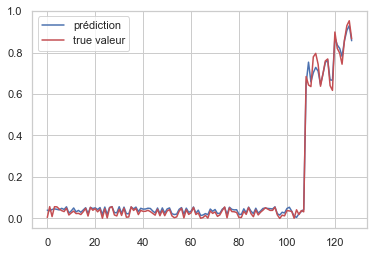

In [329]:
plt.plot(predictions[0:128],c='b',label='prédiction')
plt.plot(df_noise[0:128],c='r',label='true valeur')

plt.legend();

##  Test sur données qui comportent outliers

data with anomaly


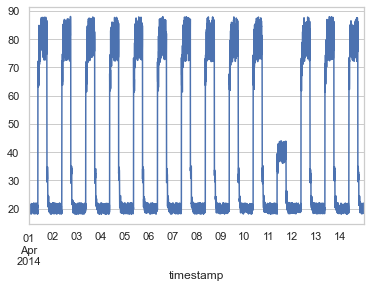

In [401]:
df_jumpdown=get_data(url='art_daily_jumpsdown.csv')

print('data with anomaly')

In [402]:
df_jumpdown=sc.transform(df_jumpdown)
val_test=np.stack(np.vsplit(df_jumpdown,14))
predictions_test=predict(val_test)

In [368]:
#from sklearn.metrics import mean_absolute_error

#mae_loss = mean_absolute_error(predictions_test,df_jumpdown)

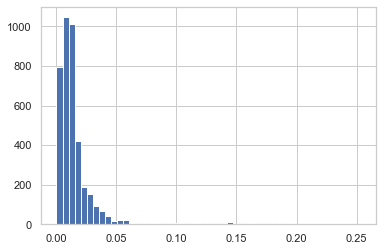

In [403]:
mae_loss_test = np.mean(np.abs(predictions_test - df_jumpdown), axis=1)
plt.hist(mae_loss_test, bins=50);


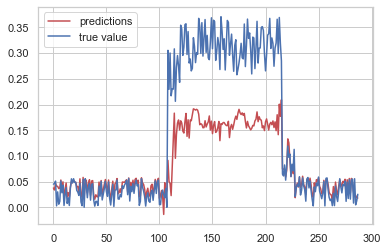

In [404]:
plt.plot(predictions_test[2880:3168],c='r',label='predictions')
plt.plot(df_jumpdown[2880:3168],label='true value');
plt.legend()

In [408]:
data=pd.DataFrame(df_jumpdown)

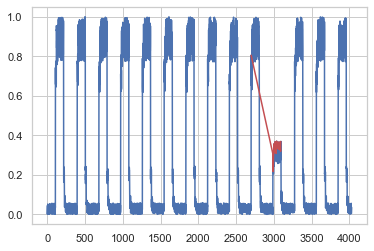

In [412]:
fig,ax=plt.subplots()

data.plot(legend=False,ax=ax)
data[mae_loss_test>threshold].plot(legend=False,ax=ax,c='r');